In [1]:
%load_ext autoreload
%autoreload 2

In [118]:
from bayesinsight import BayesInsightModel
import numpyro

numpyro.set_platform("cpu")
numpyro.set_host_device_count(16)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

In [36]:
model = BayesInsightModel.load("new_model")

In [37]:
prior = model.get_prior_predictive()

/home/mattr/Scratch/BayesInsight/bayesinsight/models/model.py:219: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior = pm.sample_prior_predictive()
Sampling: [LLT_LLT::splines_beta_mu, LLT_LLT::splines_betas, LLT_LLT::splines_betas_sd, LLT_LLT::tau, OLV Impressions_Total_Total_Total_K_, OLV Impressions_Total_Total_Total_fixed_coeff, OLV Impressions_Total_Total_Total_lag, OLV Impressions_Total_Total_Total_n_, OLV Impressions_Total_Total_Total_rand_coeff, OLV Impressions_Total_Total_Total_rand_coeff_sigma, OLV Impressions_Total_Total_Total_retention_rate_log, Price_Total_Total_Total_fixed_coeff, Price_Total_Total_Total_rand_coeff, Price_Total_Total_Total_rand_coeff_sigma, Unit Sales_Total_Total_Total_likelihood, Unit Sales_Total_Total_Total_sigma, annual_seasonality_0_fixed_coeff, annual_seasonality_0_rand_coeff, annual_seasonality_0_rand_coeff_sigma, annual_season

In [38]:
prior.prior_predictive

<xarray.Dataset> Size: 7MB
Dimensions:                                  (chain: 1, draw: 500,
                                              Geography: 4, Product: 2,
                                              Period: 208)
Coordinates:
  * chain                                    (chain) int64 8B 0
  * draw                                     (draw) int64 4kB 0 1 2 ... 498 499
  * Geography                                (Geography) <U2 32B 'CA' ... 'TX'
  * Product                                  (Product) <U1 8B 'X' 'Y'
  * Period                                   (Period) datetime64[ns] 2kB 2020...
Data variables:
    Unit Sales_Total_Total_Total_likelihood  (chain, draw, Geography, Product, Period) float64 7MB ...
Attributes:
    created_at:                 2024-10-21T02:11:42.003361+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2

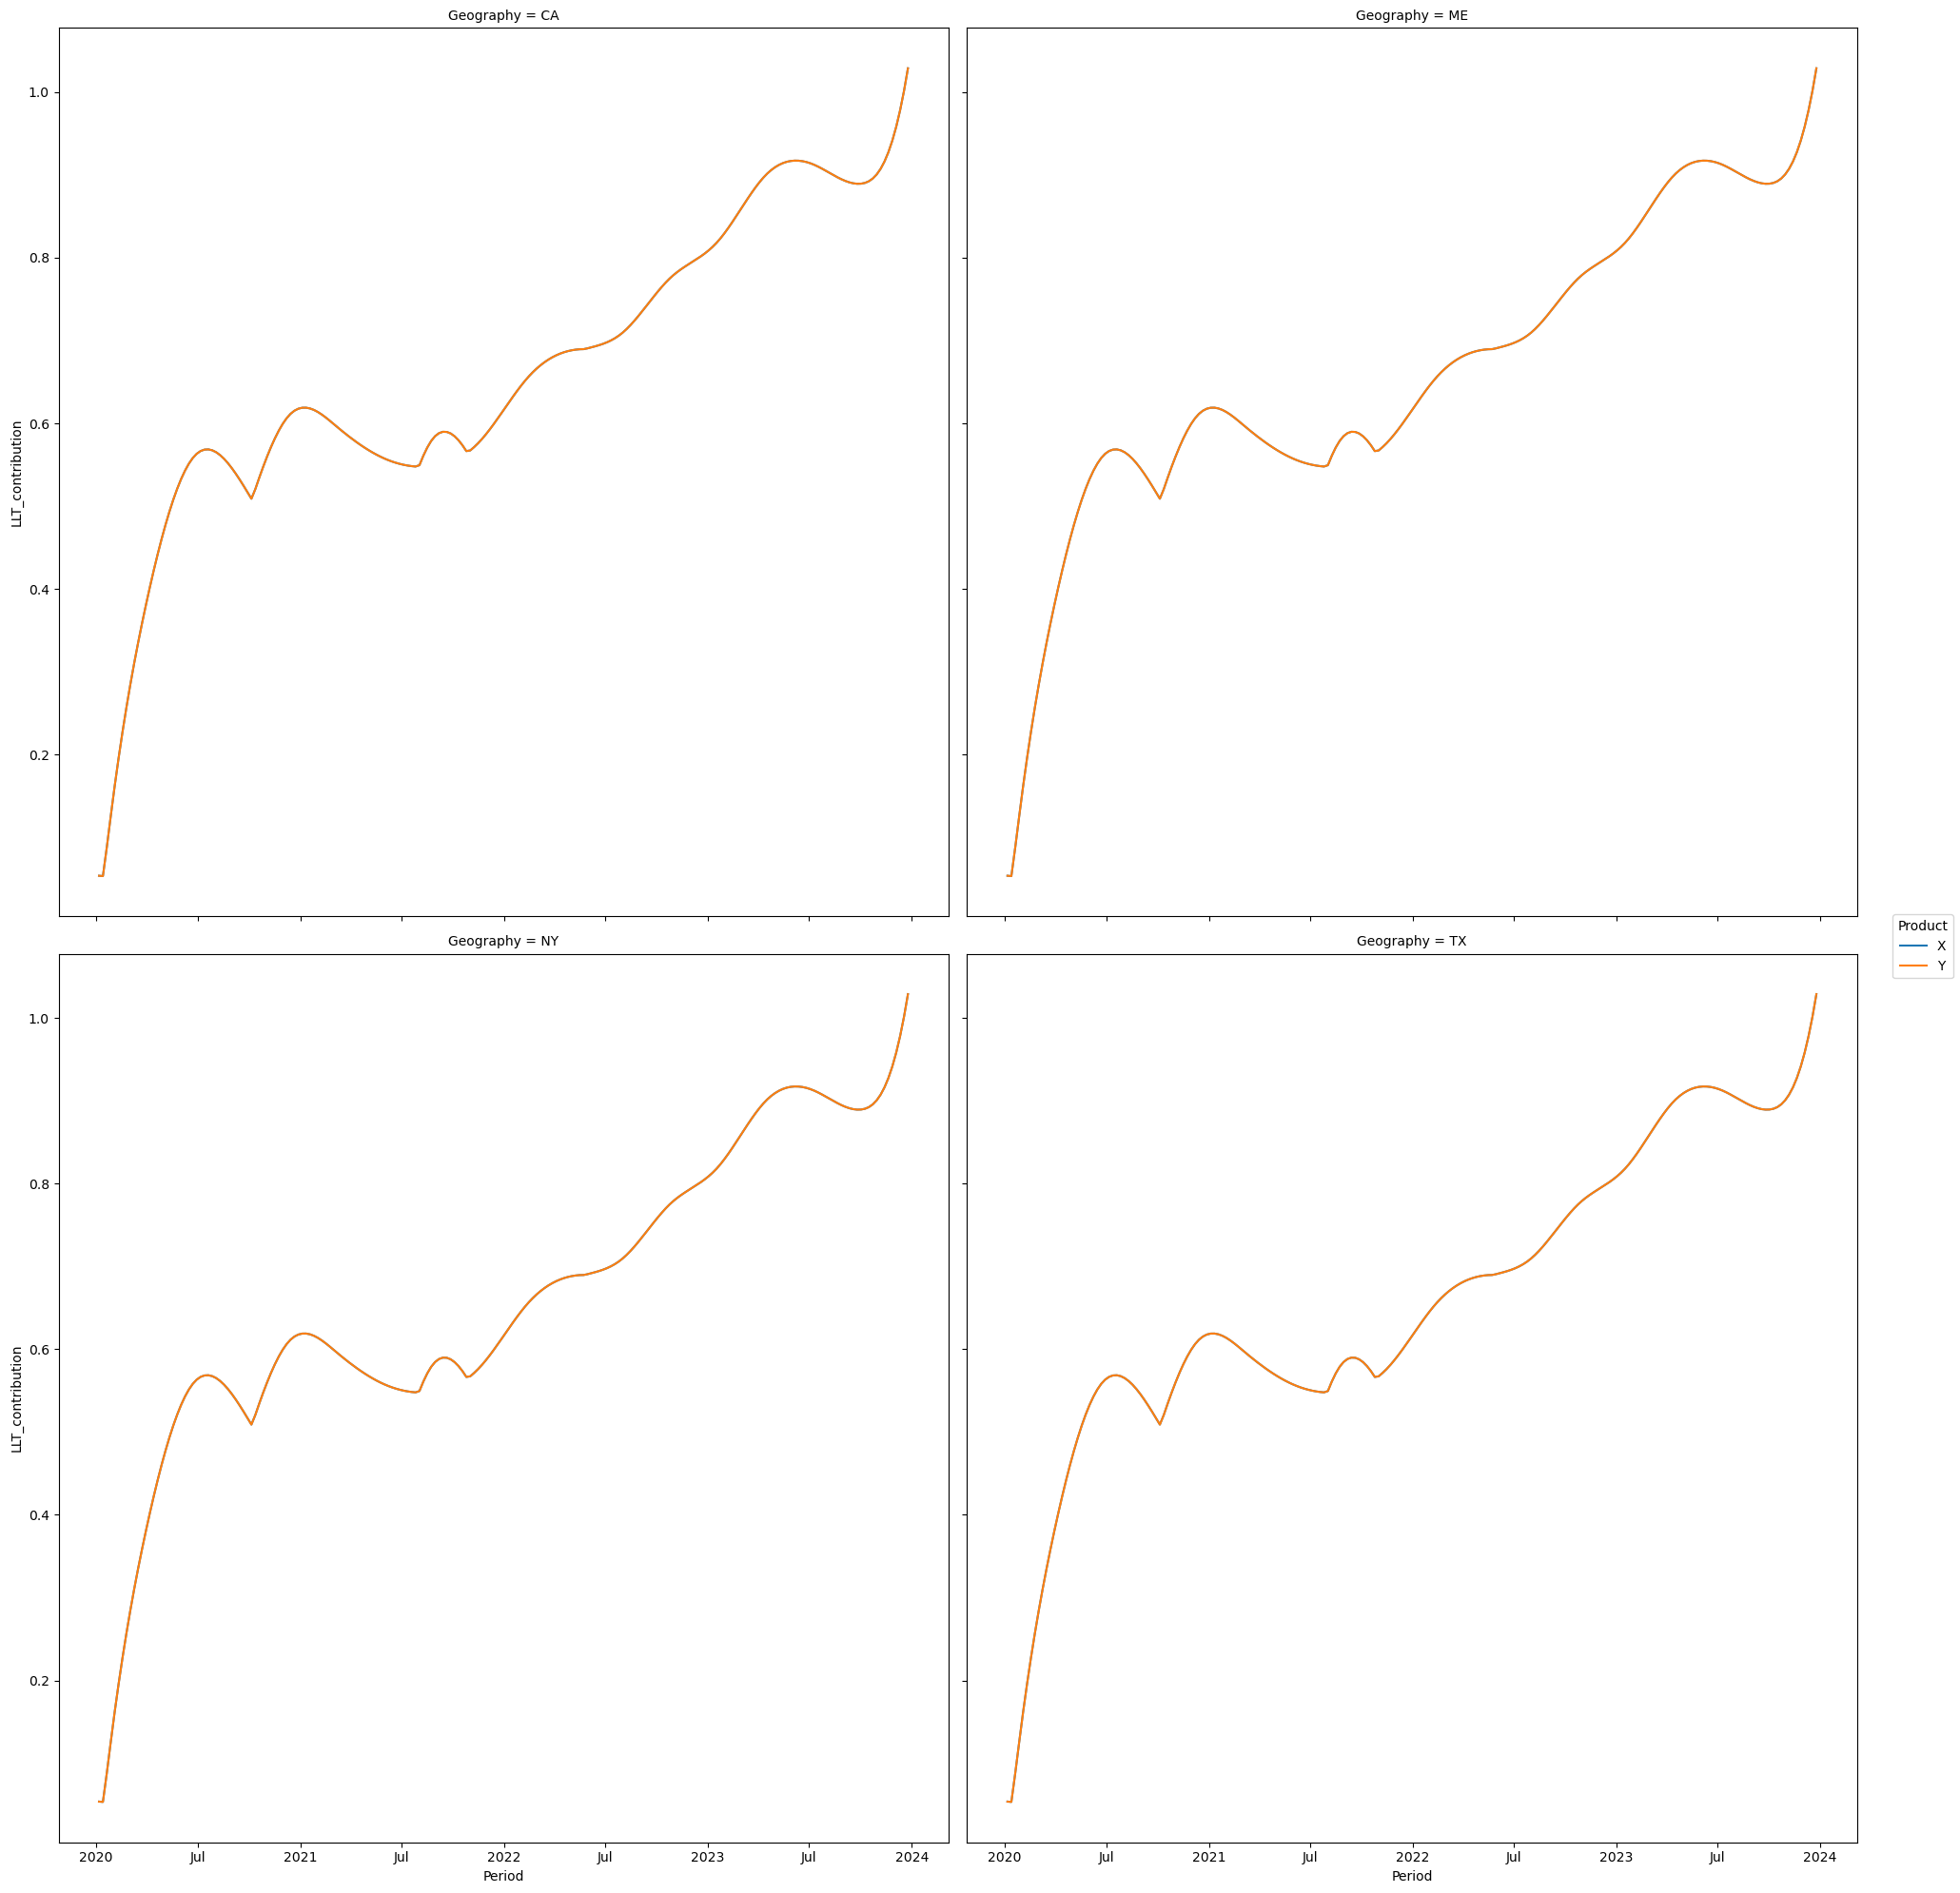

In [39]:
(prior.prior["LLT_contribution"]).max(dim=("chain", "draw")).plot(
    x="Period", col="Geography", hue="Product", col_wrap=2, figsize=(20, 20)
)

In [40]:
model.fit(nuts_sampler="numpyro")

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 105 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


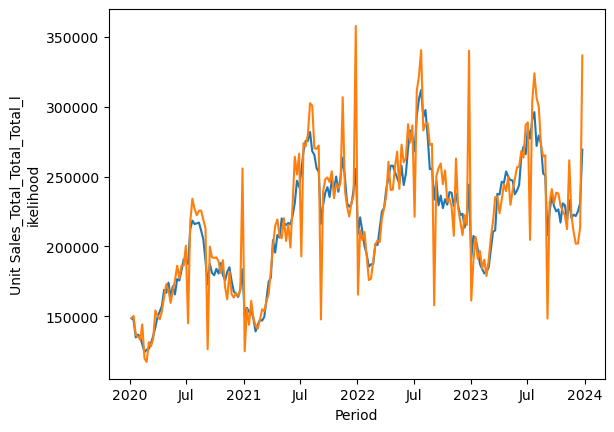

In [51]:
np.exp(model.trace.posterior.mu).sum(dim=("Geography", "Product")).mean(
    dim=("chain", "draw")
).plot(x="Period", ax=plt.gca())
model.trace.observed_data["Unit Sales_Total_Total_Total_likelihood"].sum(
    dim=("Geography", "Product")
).plot(x="Period", ax=plt.gca())

In [53]:
contributions = model.get_contributions()
avm = model.avm()

/home/mattr/Scratch/BayesInsight/bayesinsight/models/model.py:292: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  posterior = pm.sample_posterior_predictive(self.trace)
Sampling: [Unit Sales_Total_Total_Total_likelihood]


Output()

In [54]:
avm.head()

,Geography,Product,Period,Unit Sales_Total_Total_Total,Unit Sales_Total_Total_Total_likelihood,mu
0,CA,X,2020-01-06,18672.547183,18138.904562,9.795038
1,CA,X,2020-01-13,18638.570526,17591.446672,9.764117
2,CA,X,2020-01-20,16319.794361,15955.032698,9.669466
3,CA,X,2020-01-27,14921.534348,15063.465405,9.612111
4,CA,X,2020-02-03,16040.427142,16990.374182,9.728451


In [55]:
model.return_exog_variables()

[ExogVariableDetails(variable_name='Unit Sales_Total_Total_Total', variable_type='exog', deterministic_transform=DeterministicTransform(functional_form=<FunctionalForms.linear: 'linear'>, params=None), normalization=<Normilization.none: 'none'>, std=None, mean=None, time_transform=None, sign=None, partial_pooling_sigma=0.2, intercept_prior=InterceptPrior(coeff_dist=<Distribution.normal: 'Normal'>, coeff_params={'mu': 0.0, 'sigma': 0.5}), fixed_ind_coeff_dims=None, random_coeff_dims=['Geography', 'Product'], likelihood=Likelihood(type=<LikelihoodType.lognormal: 'LogNormal'>, dispersion_dims=None))]

In [56]:
model.data.metadata.row_ids

('Geography', 'Product', 'Period')

In [213]:
def sum_over_vars(dataset: xr.Dataset, name: str):
    data_vars = list(dataset.data_vars)
    accum = dataset[data_vars[0]]
    for var in data_vars[1:]:
        accum = accum + dataset[var]
    accum = accum.to_dataset(name=name)
    return accum


def calculate_mult_contributions(
    avm: pd.DataFrame,
    contributions: pd.DataFrame,
    row_ids: list[str],
    base_vars: list,
    inc_vars: list,
    exog_var: str,
    trace=None,
):
    contributions = contributions.set_index(row_ids)
    avm = xr.Dataset.from_dataframe(avm.set_index(row_ids))
    contributions = xr.Dataset.from_dataframe(contributions)

    exog_var_name = exog_var
    weekly_error = np.log(avm[exog_var_name]) - avm["mu"]

    media_vars_name = [f"{var}_contribution" for var in inc_vars]
    media_vars_contributions = contributions[media_vars_name]
    base_var_contributions = contributions[
        [var for var in list(contributions.data_vars) if var not in media_vars_name]
    ]
    base_var_contributions["weekly_error"] = weekly_error
    base_vars = [f"{var}_contribution" for var in base_vars]
    do_not_breakout = [
        var for var in list(base_var_contributions.data_vars) if var not in base_vars
    ]
    base_var_contributions = base_var_contributions.assign(
        sum_over_vars(base_var_contributions[do_not_breakout], "total_intercept")
    )
    base_var_contributions = base_var_contributions[["total_intercept"] + base_vars]

    inc_contributions = sum_over_vars(media_vars_contributions, "inc_contributions")
    base_contributions = sum_over_vars(base_var_contributions, "base_contributions")

    total_contributions = inc_contributions.assign(base_contributions)
    total_contributions["total_contributions"] = (
        total_contributions["inc_contributions"]
        + total_contributions["base_contributions"]
    )
    total_contributions_exp = np.exp(total_contributions)
    total_contributions_exp["inc_contributions_syn"] = (
        total_contributions_exp["total_contributions"]
        - total_contributions_exp["base_contributions"]
    )
    total_contributions_exp["base_contributions_syn"] = (
        total_contributions_exp["total_contributions"]
        - total_contributions_exp["inc_contributions"]
    )
    total_contributions_exp["base_contributions_norm"] = (
        total_contributions_exp["base_contributions_syn"]
        / (
            total_contributions_exp["base_contributions_syn"]
            + total_contributions_exp["inc_contributions_syn"]
        )
        * total_contributions_exp["total_contributions"]
    )
    total_contributions_exp["inc_contributions_norm"] = (
        total_contributions_exp["inc_contributions_syn"]
        / (
            total_contributions_exp["base_contributions_syn"]
            + total_contributions_exp["inc_contributions_syn"]
        )
        * total_contributions_exp["total_contributions"]
    )

    inc_contributions_exp = np.exp(
        sum_over_vars(media_vars_contributions, "total")["total"]
    ) - np.exp(
        sum_over_vars(media_vars_contributions, "total")["total"]
        - media_vars_contributions
    )
    base_contributions_exp = np.exp(
        sum_over_vars(base_var_contributions, "total")["total"]
    ) - np.exp(
        sum_over_vars(base_var_contributions, "total")["total"] - base_var_contributions
    )

    inc_contributions_exp = (
        inc_contributions_exp
        / sum_over_vars(inc_contributions_exp, "total")["total"]
        * total_contributions_exp["inc_contributions_norm"]
    )
    base_contributions_exp = (
        base_contributions_exp
        / sum_over_vars(base_contributions_exp, "total")["total"]
        * total_contributions_exp["base_contributions_norm"]
    )

    return inc_contributions_exp, base_contributions_exp, total_contributions_exp

In [214]:
contributions = model.get_contributions()

In [239]:
inc_conts, base_conts, total_conts = calculate_mult_contributions(
    avm,
    contributions,
    row_ids=["Geography", "Product", "Period"],
    base_vars=["annual_seasonality", "LLT"],
    inc_vars=["OLV Impressions_Total_Total_Total"],
    exog_var="Unit Sales_Total_Total_Total",
)

In [240]:
inc_conts

<xarray.Dataset> Size: 15kB
Dimensions:                                         (Geography: 4, Product: 2,
                                                     Period: 208)
Coordinates:
  * Geography                                       (Geography) object 32B 'C...
  * Product                                         (Product) object 16B 'X' 'Y'
  * Period                                          (Period) datetime64[ns] 2kB ...
Data variables:
    OLV Impressions_Total_Total_Total_contribution  (Geography, Product, Period) float64 13kB ...

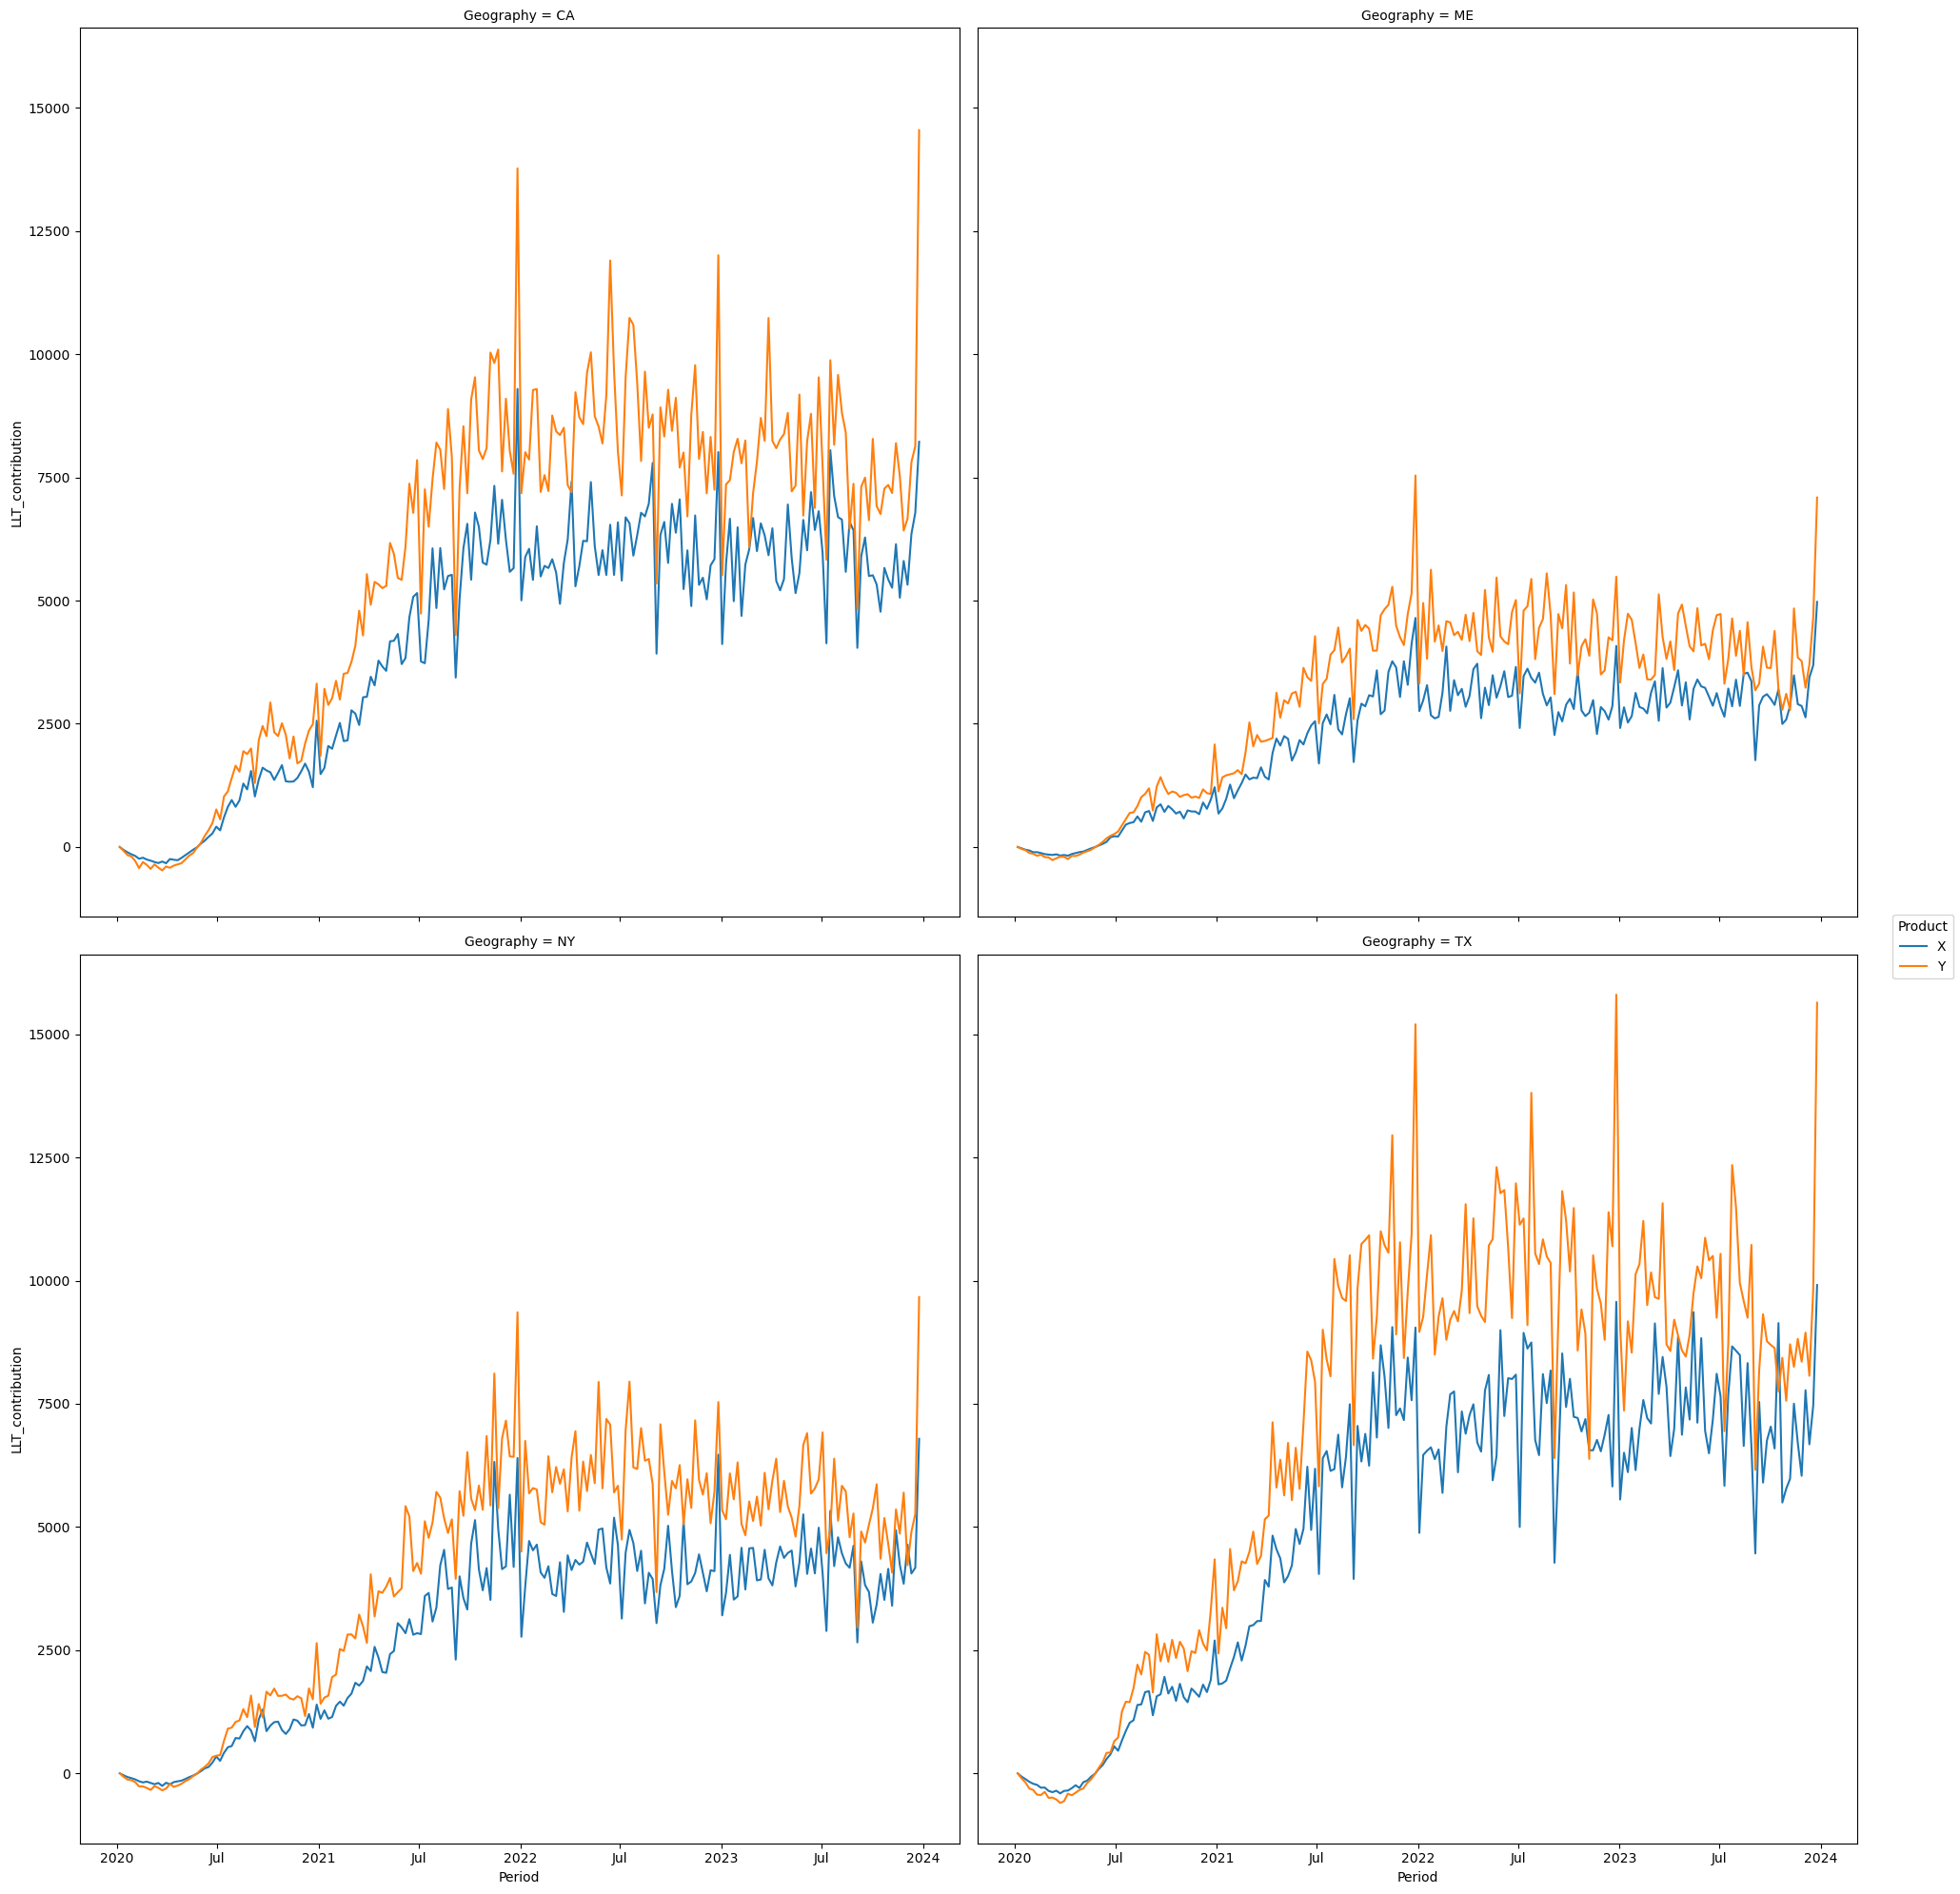

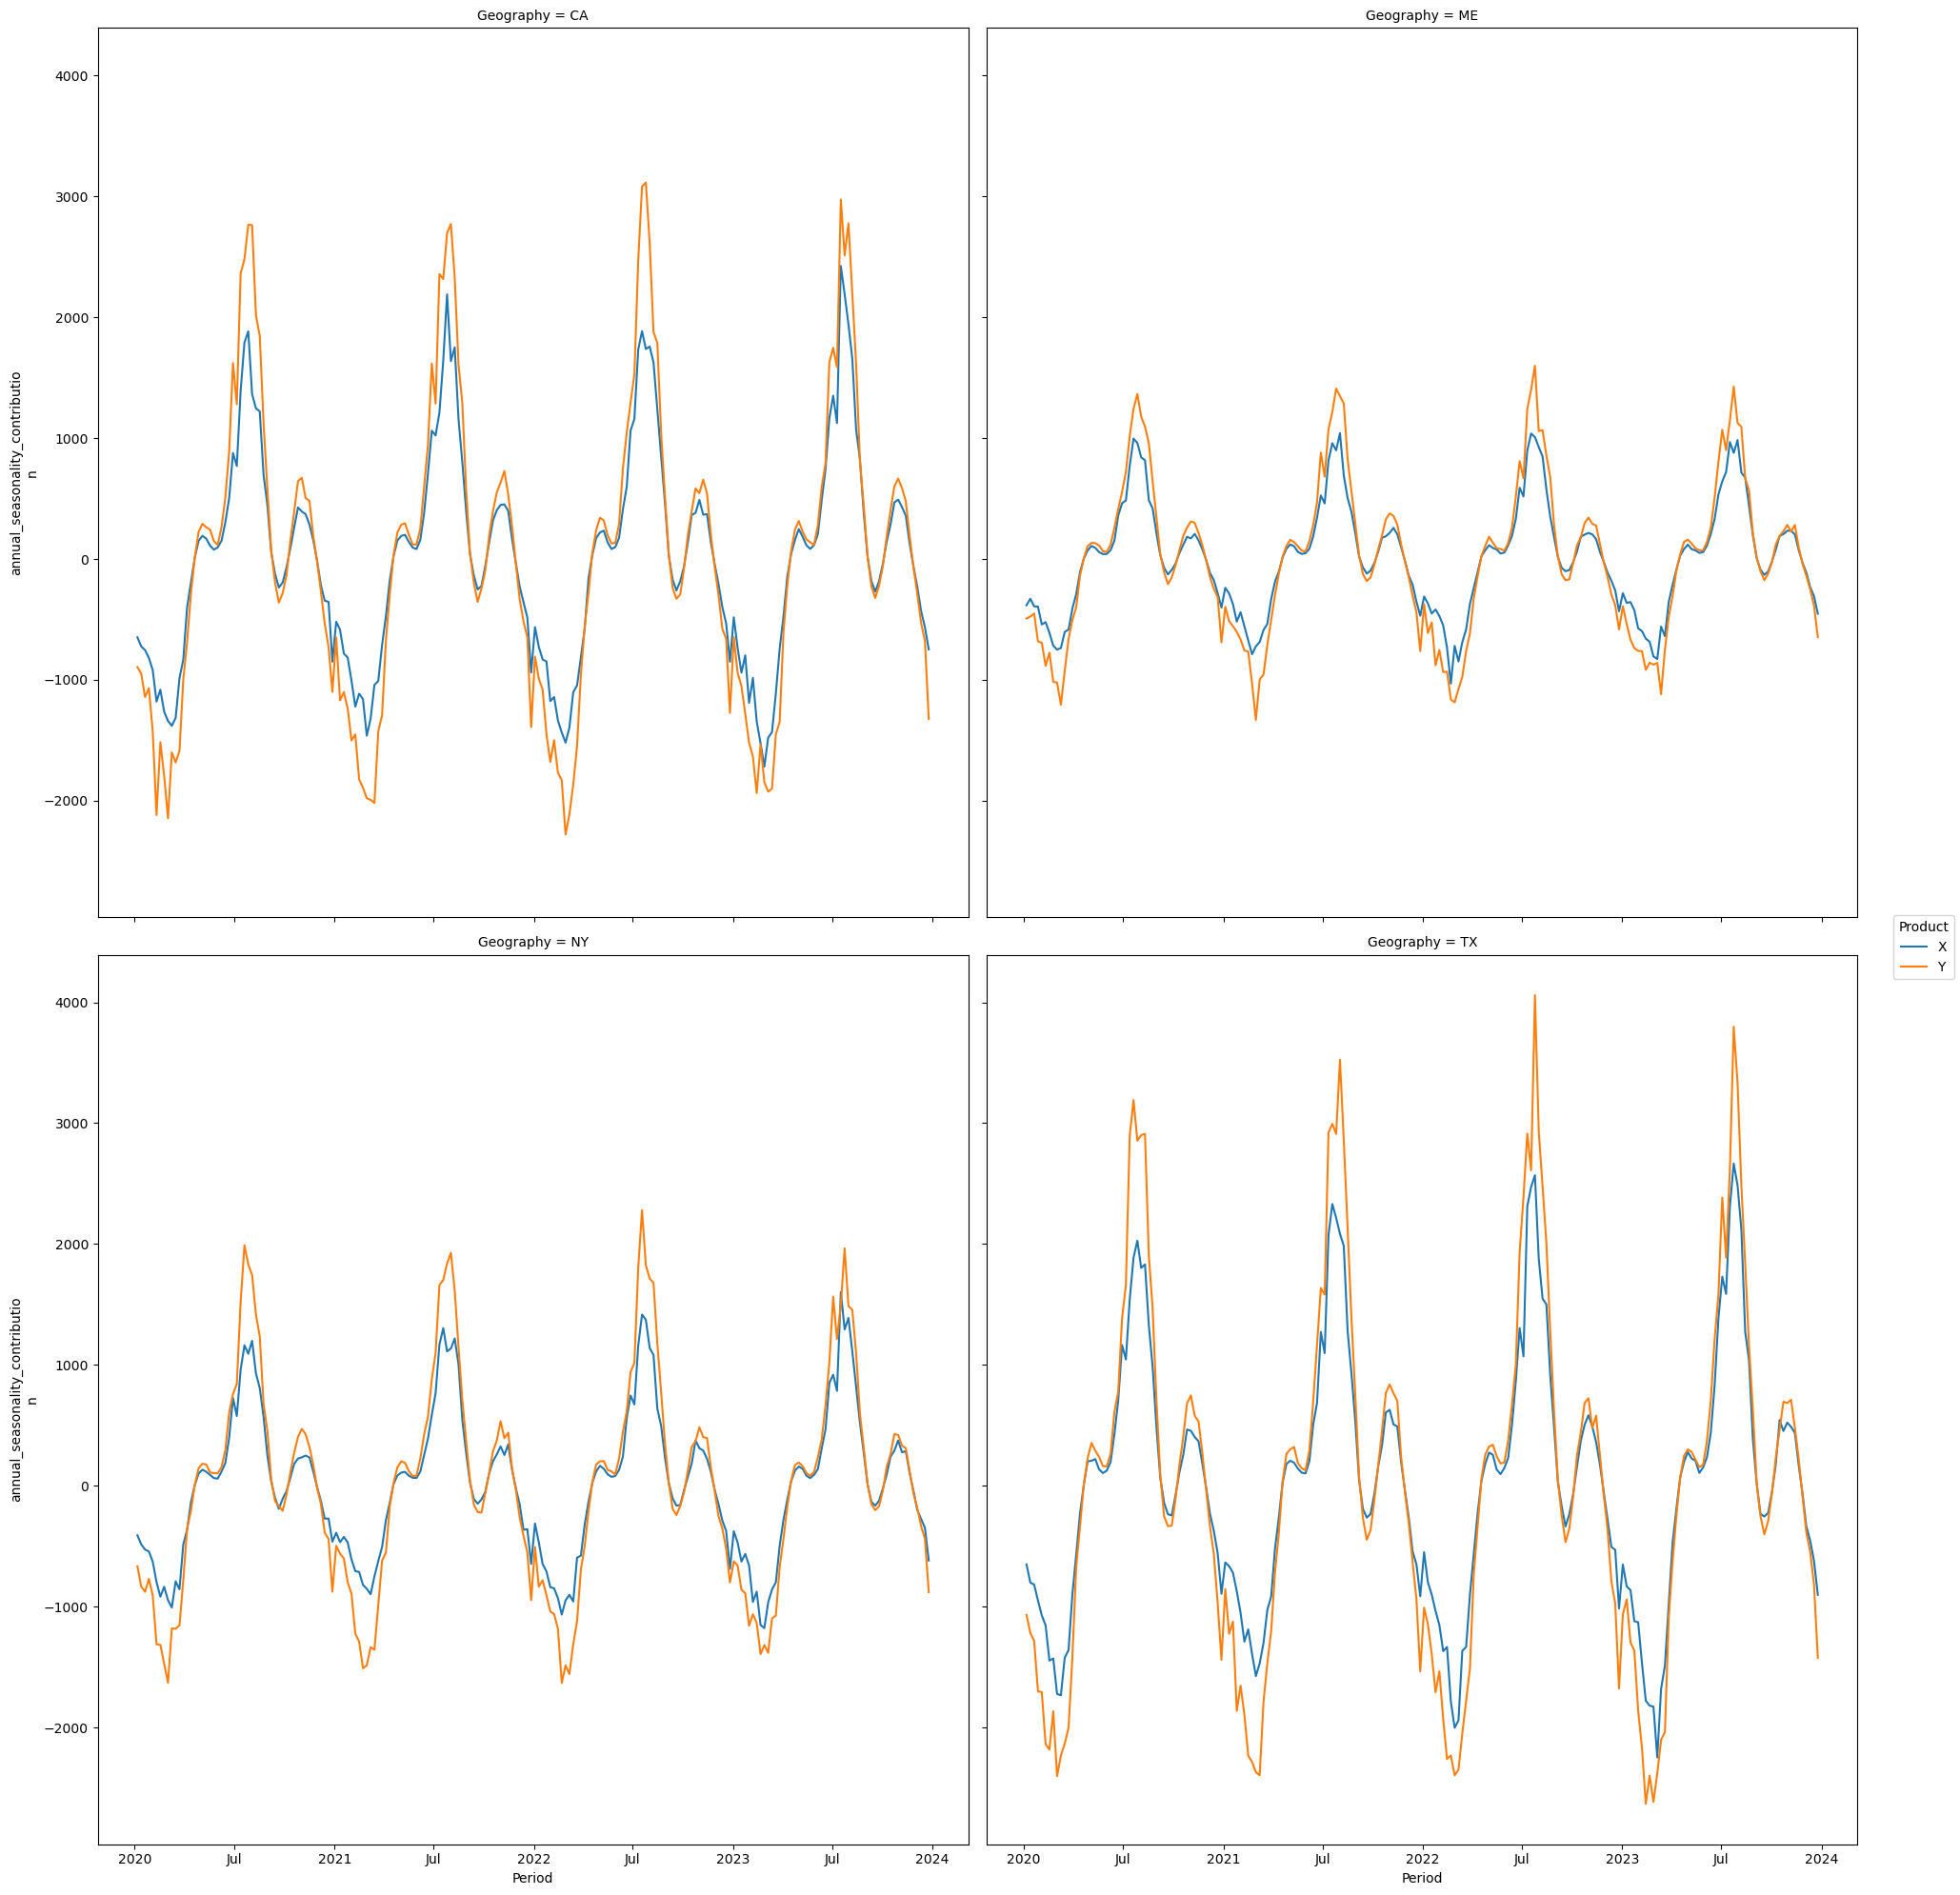

In [243]:
base_conts["LLT_contribution"].plot(
    x="Period", col="Geography", hue="Product", col_wrap=2, figsize=(20, 20)
)
base_conts["annual_seasonality_contribution"].plot(
    x="Period", col="Geography", hue="Product", col_wrap=2, figsize=(20, 20)
)

<xarray.Dataset> Size: 28kB
Dimensions:                          (Geography: 4, Product: 2, Period: 208)
Coordinates:
  * Geography                        (Geography) object 32B 'CA' 'ME' 'NY' 'TX'
  * Product                          (Product) object 16B 'X' 'Y'
  * Period                           (Period) datetime64[ns] 2kB 2020-01-06 ....
Data variables:
    total_intercept                  (Geography, Product, Period) float64 13kB ...
    annual_seasonality_contribution  (Geography, Product, Period) float64 13kB ...

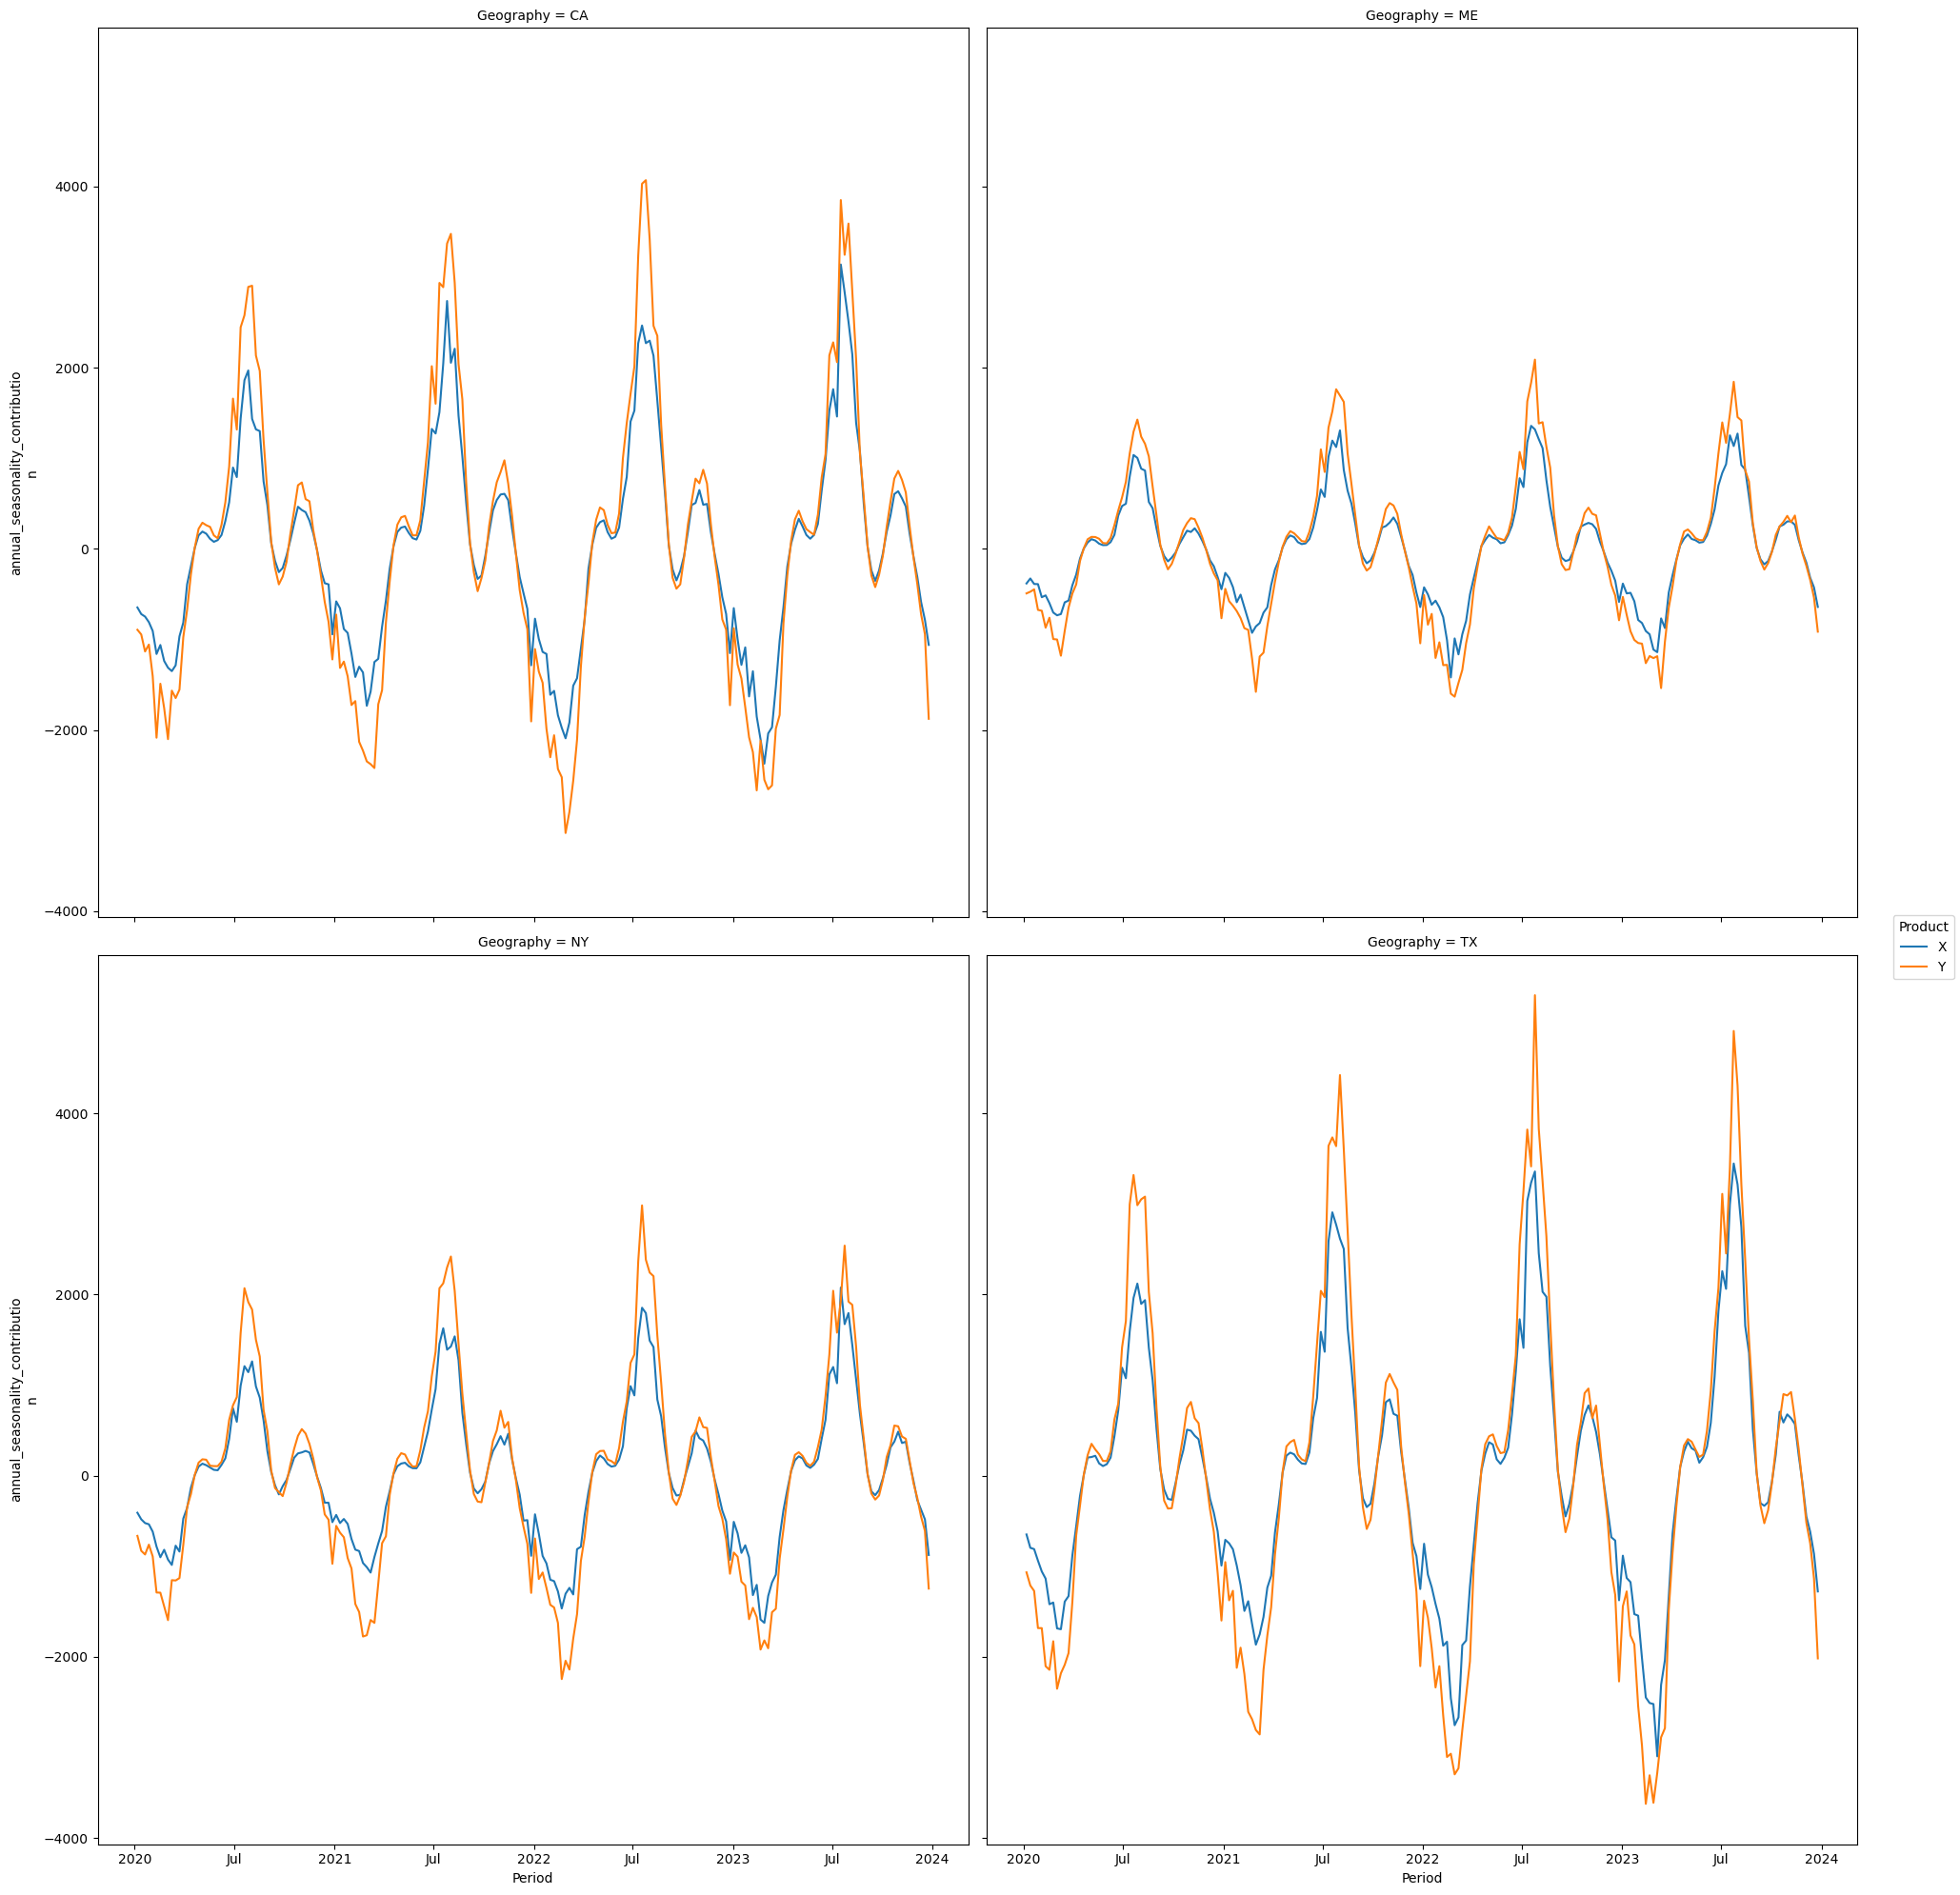

In [206]:
base_conts.annual_seasonality_contribution.plot(
    x="Period", col="Geography", hue="Product", col_wrap=2, figsize=(20, 20)
)

In [185]:
total_conts.total_contributions

<xarray.DataArray 'total_contributions' (Geography: 4, Product: 2, Period: 208)> Size: 13kB
array([[[18672.5471832 , 18638.57052635, 16319.79436149, ...,
         29835.13177134, 29671.15253001, 35243.46343896],
        [26689.59727974, 24453.79365705, 25362.14750319, ...,
         34451.55863282, 33541.34061574, 68383.56587925]],

       [[10107.87014758,  8586.79923833,  8853.91894884, ...,
         15195.80159483, 14639.18556159, 20836.89069191],
        [14259.06017546, 11892.36242024,  9389.93942133, ...,
         16558.01586411, 20767.22095972, 30436.33439638]],

       [[11604.52752657, 12558.6012946 , 11168.73663698, ...,
         18578.71639239, 17840.29346765, 30330.93819045],
        [18650.77677223, 20480.66367285, 19228.53045058, ...,
         21516.21877505, 22991.5203476 , 43807.08232127]],

       [[18420.35835154, 20969.8482077 , 17536.62669154, ...,
         29954.30259248, 31625.28583725, 44894.10866249],
        [30327.53426441, 32759.77396938, 28889.91522646, ...,
         36023.67603886, 42778.56922745, 62639.69786943]]])
Coordinates:
  * Geography  (Geography) object 32B 'CA' 'ME' 'NY' 'TX'
  * Product    (Product) object 16B 'X' 'Y'
  * Period     (Period) datetime64[ns] 2kB 2020-01-06 2020-01-13 ... 2023-12-25

In [125]:
tak = xr.Dataset.from_dataframe(total_contributions_exp[1])

In [142]:
tak.assign(ta=tak["inc_contributions"])

<xarray.Dataset> Size: 82kB
Dimensions:                 (Geography: 4, Product: 2, Period: 208)
Coordinates:
  * Geography               (Geography) object 32B 'CA' 'ME' 'NY' 'TX'
  * Product                 (Product) object 16B 'X' 'Y'
  * Period                  (Period) datetime64[ns] 2kB 2020-01-06 ... 2023-1...
Data variables:
    inc_contributions       (Geography, Product, Period) float64 13kB 2.903e+...
    base_contributions      (Geography, Product, Period) float64 13kB 1.577e+...
    total_contributions     (Geography, Product, Period) float64 13kB 1.867e+...
    inc_contributions_syn   (Geography, Product, Period) float64 13kB 3.438e+...
    base_contributions_syn  (Geography, Product, Period) float64 13kB 1.867e+...
    ta                      (Geography, Product, Period) float64 13kB 2.903e+...

In [134]:
sum_over_vars(total_contributions_exp[0], "Total_contributions")

<xarray.Dataset> Size: 15kB
Dimensions:              (Geography: 4, Product: 2, Period: 208)
Coordinates:
  * Geography            (Geography) object 32B 'CA' 'ME' 'NY' 'TX'
  * Product              (Product) object 16B 'X' 'Y'
  * Period               (Period) datetime64[ns] 2kB 2020-01-06 ... 2023-12-25
Data variables:
    Total_contributions  (Geography, Product, Period) float64 13kB 5.945e+04 ...

In [104]:
total_contributions_exp[1]

inc_contributions  base_contributions  \
Geography Product Period                                              
CA        X       2020-01-06        2903.330469        15769.216715   
                  2020-01-13        2637.196065        16001.374461   
                  2020-01-20        1323.108390        14996.685971   
                  2020-01-27         629.954075        14291.580273   
                  2020-02-03        2216.734815        13823.692327   
...                                         ...                 ...   
TX        Y       2023-11-27        7763.758685        33757.140516   
                  2023-12-04        9709.662710        34757.092819   
                  2023-12-11        5994.692391        30028.983648   
                  2023-12-18        7869.351048        34909.218179   
                  2023-12-25        9597.176533        53042.521336   

                              total_contributions  inc_contributions_syn  \
Geography Product Period                                                   
CA        X       2020-01-06         18672.547183            3437.648026   
                  2020-01-13         18638.570526            3071.636590   
                  2020-01-20         16319.794361            1439.745139   
                  2020-01-27         14921.534348             657.675511   
                  2020-02-03         16040.427142            2572.014220   
...                                           ...                    ...   
TX        Y       2023-11-27         41520.899200            9549.036271   
                  2023-12-04         44466.755529           12421.744442   
                  2023-12-11         36023.676039            7191.164687   
                  2023-12-18         42778.569227            9642.995079   
                  2023-12-25         62639.697869           11333.407729   

                              base_contributions_syn  
Geography Product Period                              
CA        X       2020-01-06            18671.321540  
                  2020-01-13            18637.373208  
                  2020-01-20            16318.697605  
                  2020-01-27            14920.488240  
                  2020-02-03            16039.236176  
...                                              ...  
TX        Y       2023-11-27            41519.600530  
                  2023-12-04            44465.367895  
                  2023-12-11            36022.426627  
                  2023-12-18            42777.278211  
                  2023-12-25            62638.476972  

[1664 rows x 5 columns]